This notebook first uses fluxes from a pre-defined OCIM (Ocean Circulation Inverse Model) to explain the composition of each gridbox in the ocean corresponding to the GP02 cruise transect in terms of the fractional contributions from user-defined `end-members'. These results are then used to refine the solution produced by pyompa (a software for conducting OMP analysis) to choose an OMP solution that most resembles the OCIM solution while maintaining residuals comparable to the best OMP solution.

This notebook was adapted from a notebook of Avanti Shrikumar (avanti@cs.stanford.edu)'s notebooks for GP02 by Rian Lawrence in the Casciotti lab at Stanford (https://nitrogen.stanford.edu/)

# Use OCIM to perform water mass analysis for the GP02 transect

Our goal will be to explain observations gathered from the GP02 cruise in terms of user-specified end-members using the fluxes from OCIM2.

First, this notebook uses an older version of python (3.7). Download notebook and install on computer. Ensure homebrew, pyenv, and pipenv installed on Mac

Second, in terminal, run below code (see https://saturncloud.io/blog/how-to-use-pipenv-pyenv-and-jupyter-for-efficient-python-development/ for how-to)

#mkdir ocim_dir

#cd ocim_dir

pyenv local 3.7.13

pipenv --python 3.7.13

pipenv install pandas numpy matplotlib jupyter

pipenv run jupyter notebook

helpful link for conda vs pip install-- https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/

## Install and import needed software


In [14]:
!echo $PATH

/Users/rianlawrence/.pyenv/shims:/Users/rianlawrence/.pyenv/bin:/Users/rianlawrence/.pyenv/bin:/Users/rianlawrence/opt/anaconda3/bin:/Users/rianlawrence/opt/anaconda3/condabin:/opt/local/bin:/opt/local/sbin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin


CHECK VERSION OF PYTHON

In [15]:
!which python
!python --version
!echo $PYTHONPATH

/Users/rianlawrence/.pyenv/shims/python
Python 3.7.13



In [16]:
!python3 --version

Python 3.7.13


### Install packages

In [17]:
import sys
!{sys.executable} -m pip install metis

In [18]:
import sys
!{sys.executable} -m pip install scikit-umfpack

setting up

Install and load the gp02wam module module, which has configuration settings for the GP02 OMP analysis as well as other handy functions for loading the data

In [19]:
!git config --global user.email rian@stanford.edu

In [20]:
#!pip install "git+https://github.com/nitrogenlab/gp15wmascripts/tree/main/GP02wma#egg=requests"
#!rm -rf gp15wmascripts
#!git clone https://github.com/nitrogenlab/gp15wmascripts
#%cd /Users/rianlawrence/Downloads/gp15wmascripts/GP02wma
#import sys
#!{sys.executable} -m pip uninstall -y GP02wma
!{sys.executable} -m pip install "git+https://github.com/nitrogenlab/gp15wmascripts.git@main#egg=gp02wma&subdirectory=GP02wma"
!{sys.executable} -m pip install "git+https://github.com/nitrogenlab/gp15wmascripts.git#egg=gp15wma"

### Import all the relevant modules

In [21]:
#!{sys.executable} -m pip uninstall -y pyompa
!{sys.executable} -m pip install "git+https://github.com/nitrogenlab/pyompa.git#egg=pyompa"

In [22]:
import numpy as np
from matplotlib import pyplot as plt
import gsw
import pandas 
from collections import OrderedDict, namedtuple
from datetime import datetime
import json
import gc
import scipy.io
import scipy.sparse
import scipy.sparse.linalg
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import (isspmatrix_csc, isspmatrix_csr, isspmatrix,
                          SparseEfficiencyWarning, csc_matrix, csr_matrix)
from scipy.sparse.sputils import is_pydata_spmatrix
import scikits.umfpack as umfpack
import copy
import netCDF4
import pyompa
import gp15wma
import GP02wma

## Load the OCIM data

### Download the OCIM data

OCIM data are from https://figshare.com/articles/dataset/OCIM2-48L_base_state_model_output/14802732. Had to download and save on local PC.

### Load the transport matrix

We load the original transport matrix

In [23]:
base_transport = scipy.io.loadmat("/Users/rianlawrence/Downloads/ocim_dir/OCIM2_48L_base_transport.mat")['TR']

### Load other relevant base data

Load latitude, longitude and depth co-ordinates for gridboxes from OCIM2_48L_base_data.nc.

In [24]:
data = netCDF4.Dataset("/Users/rianlawrence/Downloads/ocim_dir/OCIM2_48L_base/OCIM2_48L_base_data.nc")
#ocnmask is a mask indicating whether a grid cell is in the ocean
# the ocean grid cells correspond to the entries in the transport matrix
ocnmask = data.variables['ocnmask'][:].data==1.0
#ulat, ulon and wz are the lat/lon/depth coordinates corresponding to the fluxes
ulat = data.variables['ulon'][:].data #latlon are swapped in the nc file
ulon = data.variables['ulat'][:].data #latlon are swapped in the nc file
wz = data.variables['wz'][:].data

#get the mapping from depth/lon/lan to idx within ocnvec
depth_idxs, lon_idxs, lat_idxs = np.indices(ocnmask.shape)
ocnvec_mapping = np.zeros_like(ocnmask).astype("int")
ocnvec_mapping[:] = np.iinfo(np.int).max
ocnvec_mapping[(depth_idxs.ravel()[ocnmask.ravel()],
                lon_idxs.ravel()[ocnmask.ravel()],
                lat_idxs.ravel()[ocnmask.ravel()])] = np.arange(np.sum(ocnmask))
del depth_idxs, lon_idxs, lat_idxs

<ipython-input-24-213dc5de9420>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ocnvec_mapping[:] = np.iinfo(np.int).max


As a sanity check, let's do a scatterplot of all the lat/lon coordinates corresponding to the ocean gridpoints. We note that the OCIM longitude co-ordinates go fro 0 to 360.

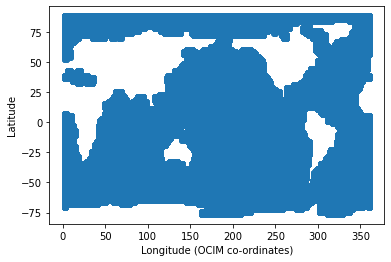

In [25]:
plt.scatter(ulon[ocnmask], ulat[ocnmask])
plt.xlabel("Longitude (OCIM co-ordinates)")
plt.ylabel("Latitude")
plt.show()

Get the latitude, longitude and depth specifically at ocean gridboxes. Also convert longitudes to have negative values west of the prime meridian, consistent with more standard notation.

In [26]:
#the _ocnvec suffix indicates the vector of properties corresponds to grid
# boxes that are in the ocean; it lines up with the axes of the transport matrix
ulat_ocnvec = ulat.ravel()[ocnmask.ravel()]
ulon_ocnvec = ulon.ravel()[ocnmask.ravel()]
#convert ulon to have negative longitudes to the west of the prime meridian,
# which makes it more compatible with what other packages expect
ulon_ocnvec = (ulon_ocnvec*(ulon_ocnvec <= 180)
               + (-(360-ulon_ocnvec)*(ulon_ocnvec > 180)))

depth_ocnvec = wz.ravel()[ocnmask.ravel()]

As a sanity check, we'll make sure that the converted longitude coordinates correspond to what we want (i.e. negative values west of the prime meridian)

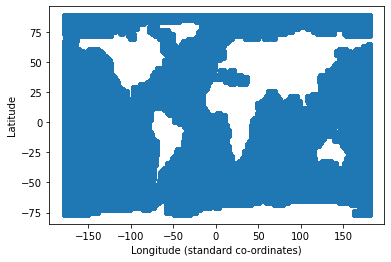

In [27]:
plt.scatter(ulon_ocnvec, ulat_ocnvec)
plt.xlabel("Longitude (standard co-ordinates)")
plt.ylabel("Latitude")
plt.show()

## Load the World Ocean Atlas data

### Download the WOA data

Key for reading the WOA data:
- s=salinity, t=temperature, i=silicate, o=oxygen  
- _an is the objectively analyzed value   
- decav is the decadal average  
- A5B7 is 2005 to 2017  (A=2000s, B=2010s). "All" indicates all time ranges. "all" is only available for nutrients and is not available for temp/salinity
- The 00 in s00/t00/i00/o00 indicates it's an annual value  
- 1.00 indicates it's for a 1-degree-resolution grid, as does the 01 suffix in the file name

In [28]:
#WOA18 for A5B7 salinity
#! [[ -e woa18_A5B7_s00_01.nc ]] || wget https://www.ncei.noaa.gov/data/oceans/woa/WOA18/DATA/salinity/netcdf/A5B7/1.00/woa18_A5B7_s00_01.nc -O woa18_A5B7_s00_01.nc

#WOA18 A5B7 temperature
#! [[ -e woa18_A5B7_t00_01.nc ]] || wget https://www.ncei.noaa.gov/data/oceans/woa/WOA18/DATA/temperature/netcdf/A5B7/1.00/woa18_A5B7_t00_01.nc -O woa18_A5B7_t00_01.nc

#WOA18 "all" silicate
#! [[ -e woa18_all_i00_01.nc ]] || wget https://www.ncei.noaa.gov/data/oceans/woa/WOA18/DATA/silicate/netcdf/all/1.00/woa18_all_i00_01.nc -O woa18_all_i00_01.nc

#WOA18 "all" oxygen
#! [[ -e woa18_all_o00_01.nc ]] || wget https://www.ncei.noaa.gov/data/oceans/woa/WOA18/DATA/oxygen/netcdf/all/1.00/woa18_all_o00_01.nc -O woa18_all_o00_01.nc


### Load WOA into a pandas data frame

In [29]:
def extract_woa_into_df(attr_to_woancdata):
    attributes = list(attr_to_woancdata.keys())
    lat_ticks = attr_to_woancdata[attributes[0]]['lat'][:].data
    lon_ticks = attr_to_woancdata[attributes[0]]['lon'][:].data
    depth_ticks = attr_to_woancdata[attributes[0]]['depth'][:].data
    #make sure the ticks are the same across all woancdata entries, as a
    # sanity check
    for attr in attr_to_woancdata:
        assert tuple(lat_ticks) == tuple(attr_to_woancdata[attr]['lat'][:].data)
        assert tuple(lon_ticks) == tuple(attr_to_woancdata[attr]['lon'][:].data)
        assert tuple(depth_ticks) == tuple(
                                       attr_to_woancdata[attr]['depth'][:].data)

    attr_to_data = dict([(attr, attr_to_woancdata[attr][attr][:].data)
                         for attr in attr_to_woancdata])
    attr_to_nanfill = dict([(attr, attr_to_woancdata[attr][attr]._FillValue)
                          for attr in attr_to_woancdata])

    pandas_dict = OrderedDict([
        ('depth', []),
        ('latitude', []),
        ('longitude', [])
    ])
    for attr in attr_to_woancdata:
        pandas_dict[attr] = []

    for depthidx in range(len(depth_ticks)):
        for latidx in range(len(lat_ticks)):
            for lonidx in range(len(lon_ticks)):
                #only consider points where data is present
                # for some of the readings
                data_present = any([(
                    attr_to_data[attr][0, depthidx, latidx, lonidx]
                    != attr_to_nanfill[attr]) for attr in attributes])
                if (data_present):
                    pandas_dict['depth'].append(depth_ticks[depthidx])
                    pandas_dict['latitude'].append(lat_ticks[latidx])
                    pandas_dict['longitude'].append(lon_ticks[lonidx])
                    for attr in attr_to_data:
                        dataval =\
                            attr_to_data[attr][0, depthidx, latidx, lonidx]
                        if (dataval == attr_to_nanfill[attr]):
                            dataval = np.nan
                        pandas_dict[attr].append(dataval)
    return pandas.DataFrame(pandas_dict)

woa18_df = extract_woa_into_df(
              attr_to_woancdata={
                  't_an': netCDF4.Dataset("/Users/rianlawrence/Downloads/ocim_dir/woa18_A5B7_t00_01.nc"),
                  's_an': netCDF4.Dataset("/Users/rianlawrence/Downloads/ocim_dir/woa18_A5B7_s00_01.nc"),
                  'i_an': netCDF4.Dataset("/Users/rianlawrence/Downloads/ocim_dir/woa18_all_i00_01.nc"),
                  'o_an': netCDF4.Dataset("/Users/rianlawrence/Downloads/ocim_dir/woa18_all_o00_01.nc")
                  })

Add conservative temperature, absolute salinity and potential density to the WOA data frame

In [30]:
def augment_woa_with_conservative_vals(woa_df):
    depth = np.array(woa_df["depth"])
    lats = np.array(woa_df["latitude"])
    lons = np.array(woa_df["longitude"])
    #pressure calculation from depth
    p = gsw.p_from_z(
      z=-depth, #z is expected to be negative in the ocean
      lat=lats)
    #get the absolute salinity given the practical salinity and pressure
    abssal = gsw.SA_from_SP(SP=np.array(woa_df["s_an"]), #practical salinity
                            p=p, lon=lons, lat=lats)
    #get conservative temp given absolute salinity, temp and pressure
    ctemp = gsw.CT_from_t(SA=abssal,
                          t=np.array(woa_df["t_an"]), #temperature
                          p=p)
    #get sigma2/sigma2/sigma4, which will be used for defining the locations of
    # endmembers
    sig0 = gsw.sigma0(SA=abssal, CT=ctemp)
    sig2 = gsw.sigma2(SA=abssal, CT=ctemp)
    sig4 = gsw.sigma4(SA=abssal, CT=ctemp)

    woa_df["pressure"] = p
    woa_df["absolute_salinity"] = abssal
    woa_df["conservative_temperature"] = ctemp
    woa_df["sigma0"] = sig0
    woa_df["sigma2"] = sig2
    woa_df["sigma4"] = sig4

augment_woa_with_conservative_vals(woa_df=woa18_df)

### Index WOA data by OCIM gridboxes

We organize the measurements into a data structure such that we can easily retrieve the measurements corresponding to particular OCIM gridboxes

First, we get the depth, latitude and longitude 'axes tickmarks' corresponding to the OCIM gridboxes

In [31]:
ocim_wz_ticks = tuple(wz[:,0,0])
ocim_ulat_ticks = tuple(ulat[0,0,:])
ocim_ulon_ticks = tuple(ulon[0,:,0])

#also delete obsolete variables
del data
del ulat
del ulon
del wz
gc.collect()

171

Next, we define functions that can be used for mapping the measured data into a data structure corresponding to the OCIM gridboxes. Each observation is assigned to the OCIM gridbox that has the closest value of ulat/ulon/depth.

In [32]:
#This function initializes an empty grid
def initialize_grid(shape):
    grid = []
    for depth_idx in range(shape[0]):
        grid_depthentry = []
        for lon_idx in range(shape[1]):
            grid_lonentry = []
            for lat_idx in range(shape[2]):
                grid_latentry = []
                grid_lonentry.append(grid_latentry)
            grid_depthentry.append(grid_lonentry)
        grid.append(grid_depthentry)
    return grid

#This function maps observations in a data frame into a grid
def prepare_obsgrid_from_df(df, wz_ticks, ulon_ticks, ulat_ticks,
                                depth_key, longitude_key, latitude_key,
                                keys_to_record, return_idx_mapping=False):
    obs_grid = initialize_grid((len(wz_ticks), len(ulon_ticks), len(ulat_ticks)))

    ObsEntry = namedtuple('ObsEntry', keys_to_record)

    df_lats = np.array(df[latitude_key])
    df_lons = np.array(df[longitude_key])
    df_depths = np.array(df[depth_key])

    #np.searchsorted gives the insertion index in order
    # to maintain sort order
    #Also need to convert the lons to the 0-360 system used by OCIM
    df_lons_converted = (df_lons*(df_lons >= 0.0)
                         + (df_lons + 360)*(df_lons < 0.0))
    lat_insert_idxs = np.searchsorted(a=ulat_ticks, v=df_lats)
    lon_insert_idxs = np.searchsorted(a=ulon_ticks, v=df_lons_converted)
    depth_insert_idxs = np.searchsorted(a=wz_ticks, v=df_depths)

    #also get the contents associated with keys_to_record, to avoid
    # storing unnecessarily large amounts of data
    key_to_coldata = dict([
        (key, np.array(df[key])) for key in keys_to_record
    ])

    if (return_idx_mapping):
        mapped_idxs = [[], [], []] #depth, lon, lat

    num_obs_skipped = 0
    for i in range(len(lat_insert_idxs)):
        lat_insert_idx = lat_insert_idxs[i]
        lon_insert_idx = lon_insert_idxs[i]
        depth_insert_idx = depth_insert_idxs[i]

        item_lat = df_lats[i]
        item_lon = df_lons_converted[i]
        item_depth = df_depths[i]

        #In an Arakawa-B grid, the velocities are measured in the center of
        # the grid. Thus, we want to map the observation to the gridbox
        # for which the lat/lon/depth measurement is closer.
        lat_idx = (lat_insert_idx
              if (abs(ulat_ticks[lat_insert_idx] - item_lat)
                  < abs(ulat_ticks[lat_insert_idx-1] - item_lat))
              else lat_insert_idx-1)
        #Need to do the %360 to account for wrap-around
        lon_idx = (lon_insert_idx
                  if (abs(ulon_ticks[lon_insert_idx] - item_lon)%360
                      < abs(ulon_ticks[lon_insert_idx-1] - item_lon)%360)
                   else lon_insert_idx-1)
        #If the insertion index is deeper than the tick of the deepest gridbox,
        # the index is the one corresponding to the deepest gridbox (0-indexed)
        if (depth_insert_idx == len(wz_ticks)):
            depth_idx = depth_insert_idx - 1
        else:
            depth_idx = (depth_insert_idx
            if ((abs(wz_ticks[depth_insert_idx] - item_depth)
                < abs(wz_ticks[depth_insert_idx-1] - item_depth))
                ##avoid going too deep if that gridbox is on land
                #and (ocnvec_mapping[depth_insert_idx,lon_idx,lat_idx]
                #     != np.iinfo(np.int).max)
                )
            else depth_insert_idx-1)

        #In case the gridbox mapped to corresponds to a land box, then go
        # higher at look at adjacent lat/lon until we find a non-land
        # gridbox
        c_depthidx = depth_idx
        c_lonidx = lon_idx
        c_latidx = lat_idx

        #If we don't have to return the index mapping, then we can
        # ignore cases where something maps to a land gridbox
        if (return_idx_mapping == False):
          if (ocnmask[c_depthidx, c_lonidx, c_latidx]==False):
              num_obs_skipped += 1
              continue
        else: #otherwise, go through the process of finding a match
            while (ocnmask[c_depthidx, c_lonidx, c_latidx]==False):
                if ocnmask[c_depthidx-1, c_lonidx, c_latidx]:
                    c_depthidx = c_depthidx-1 #look higher first
                    break
                #cycle through lat/lon surroundings
                if ocnmask[c_depthidx, c_lonidx-1, c_latidx]:
                    c_lonidx = c_lonidx-1
                    break
                if ocnmask[c_depthidx, (c_lonidx+1) % ocnmask.shape[1], c_latidx]:
                    c_lonidx = c_lonidx+1
                    break
                if ocnmask[c_depthidx, c_lonidx, c_latidx-1]:
                    c_latidx = c_latidx-1
                    break
                if ocnmask[c_depthidx, c_lonidx, (c_latidx+1)  % ocnmask.shape[2]]:
                    c_latidx = c_latidx+1
                    break
                if (c_depthidx==0):
                    break #don't keep looking if reached surface
                #go higher and do search again
                c_depthidx = c_depthidx - 1

        if ( (c_depthidx, c_lonidx, c_latidx) != (depth_idx, lon_idx, lat_idx)):
            print("Warning!",(item_depth, item_lon, item_lat), "is closest"
              +" to land gridbox",
              (wz_ticks[depth_idx], ulon_ticks[lon_idx],ulat_ticks[lat_idx]),
              "so mapping to",
              (wz_ticks[c_depthidx], ulon_ticks[c_lonidx],ulat_ticks[c_latidx]),
              "gridbox instead")
            depth_idx, lon_idx, lat_idx = (c_depthidx, c_lonidx, c_latidx)
        if (return_idx_mapping):
            #if (ocnvec_mapping[depth_idx,lon_idx,lat_idx]) == np.iinfo(np.int).max:
            #    print(depth_idx, lon_idx, lat_idx)
            #    print(item_depth, item_lon, item_lat)
            #    print(ocnvec_mapping[depth_idx,lon_idx,lat_idx],
            #          ocnvec_mapping[depth_idx-1,lon_idx,lat_idx],
            #          ocnvec_mapping[depth_idx-2,lon_idx,lat_idx],
            #          ocnvec_mapping[depth_idx-3,lon_idx,lat_idx])
            mapped_idxs[0].append(depth_idx)
            mapped_idxs[1].append(lon_idx)
            mapped_idxs[2].append(lat_idx)
        obs_grid[depth_idx][lon_idx][lat_idx].append(
            ObsEntry(*[key_to_coldata[key][i] for key in keys_to_record ] ))

    if (return_idx_mapping == False):
      print("Skipped",num_obs_skipped,"observations out of",
            len(lat_insert_idxs),"as the closest gridbox was a land gridbox")

    if (return_idx_mapping):
        return obs_grid, mapped_idxs
    else:
        return obs_grid

Now we run those functions to map the WOA data into gridboxes

In [33]:
woa18_obs_grid = prepare_obsgrid_from_df(df=woa18_df,
    wz_ticks=ocim_wz_ticks, ulon_ticks=ocim_ulon_ticks,
    ulat_ticks=ocim_ulat_ticks,
    depth_key="depth", longitude_key="longitude", latitude_key="latitude",
    keys_to_record=["conservative_temperature", "absolute_salinity",
                    "i_an", "o_an", "sigma0", "sigma2", "sigma4"])

Skipped 278221 observations out of 3305010 as the closest gridbox was a land gridbox


### Compute average WOA data in OCIM gridboxes

Compute things like the average silicate concentration, average conservative temperature of the WOA data in each OCIM gridbox.

In [34]:
#Function that averages the observations in each gridbox,
# returning np.nan when there are no observations in a gridbox
def get_data_from_obs_grid(func, obs_grid):
    to_return = np.zeros(
        (len(obs_grid), len(obs_grid[0]),
         len(obs_grid[0][0])) )
    to_return[:,:,:] = np.nan
    for i in range(len(obs_grid)):
        for j in range(len(obs_grid[i])):
            for k in range(len(obs_grid[i][j])):
                if len(obs_grid[i][j][k]) > 0:
                    to_return[i,j,k] = func(obs_grid[i][j][k])
    return to_return

def get_mean_from_obs_grid(attr, obs_grid):
    return get_data_from_obs_grid(
              func=eval("lambda arr: np.mean([y."+attr+" for y in arr])"),
              obs_grid=obs_grid)

#Get the mean conservative temperature, absolute salinity,
# and silicate in the ocean gridboxes with WOA18 data
woa18_mean_ctemp_ocnvec = get_mean_from_obs_grid(
    attr="conservative_temperature",
    obs_grid=woa18_obs_grid).ravel()[ocnmask.ravel()]
woa18_mean_abssal_ocnvec = get_mean_from_obs_grid(
    attr="absolute_salinity",
    obs_grid=woa18_obs_grid).ravel()[ocnmask.ravel()]
woa18_mean_silicate_ocnvec = get_mean_from_obs_grid(
    attr="i_an",
    obs_grid=woa18_obs_grid).ravel()[ocnmask.ravel()]

#also get the potential density and oxygen data as this will be
# useful for defining end-member boundaries
woa18_mean_sig0_ocnvec = get_mean_from_obs_grid(
    attr="sigma0",
    obs_grid=woa18_obs_grid).ravel()[ocnmask.ravel()]
woa18_mean_sig2_ocnvec = get_mean_from_obs_grid(
    attr="sigma2",
    obs_grid=woa18_obs_grid).ravel()[ocnmask.ravel()]
woa18_mean_sig4_ocnvec = get_mean_from_obs_grid(
    attr="sigma4",
    obs_grid=woa18_obs_grid).ravel()[ocnmask.ravel()]
woa18_mean_oxygen_ocnvec = get_mean_from_obs_grid(
    attr="o_an",
    obs_grid=woa18_obs_grid).ravel()[ocnmask.ravel()]

Save memory by deleting the objects corresponding to `woa18_obs_grid` and `woa18_df`

In [35]:
del woa18_obs_grid
del woa18_df

gc.collect()

53

## Idenitify OCIM gridboxes corresponding to end-members

We define endmembers by lat/lon/potential density and figure out the indexes in the vector of ocean gridboxes that correspond to each endmember. We also use WOA data to add in a filter on oxygen.

In [36]:
#Function to get the indexes that match a lat/lon/potential density threshold
# range. These are indexes into the vector of ocean gridboxes.
def get_endmember_idxs(lat_min, lat_max,
                      lon_min, lon_max,
                      invert_lon=False,
                      depth_min=0, depth_max=np.inf,
                      sig0_min=0, sig0_max=np.inf,
                      sig2_min=0, sig2_max=np.inf,
                      sig4_min=0, sig4_max=np.inf,
                      ox_min=0, ox_max=np.inf):
    nonzero_idxs = np.nonzero(
      (ulat_ocnvec >= lat_min)*(ulat_ocnvec <= lat_max)
     *((((ulon_ocnvec) >= lon_min)*((ulon_ocnvec) <= lon_max))
       ==(False if invert_lon else True))
     *(depth_ocnvec >= depth_min)*(depth_ocnvec <= depth_max)
     *(woa18_mean_sig0_ocnvec >= sig0_min)*(woa18_mean_sig0_ocnvec <= sig0_max)
     *(woa18_mean_sig2_ocnvec >= sig2_min)*(woa18_mean_sig2_ocnvec <= sig2_max)
     *(woa18_mean_sig4_ocnvec >= sig4_min)*(woa18_mean_sig4_ocnvec <= sig4_max)
     *(woa18_mean_oxygen_ocnvec >= ox_min)
     *(woa18_mean_oxygen_ocnvec <= ox_max)
    )[0]
    return nonzero_idxs

endmember_definitions = {
    "AAIW": {"lat_min":-55.0, "lat_max":-43.0,
             "lon_min":-90, "lon_max":-80,
             "sig0_min":27.05, "sig0_max":27.15},
    "NPIW": {"lat_min":36.5, "lat_max":39.0,
             "lon_min":148.0, "lon_max":154.0,
             "sig0_min":26.4, "sig0_max":26.9},
    "UCDW": {"lat_min":-49.5, "lat_max":-44.5,
             "lon_min":-157.0, "lon_max":-147.0,
             "sig0_min":27.35, "sig0_max":27.75},
    "LCDW": {"lat_min":-66.5, "lat_max":-61.5,
             "lon_min":-100.0, "lon_max":150.0,
             "invert_lon":True,
             "sig0_min":27.79, "sig0_max":27.83},
    "AABW": {"lat_min":-66.5, "lat_max":-61.5,
             "lon_min":-100.0, "lon_max":150.0,
             "invert_lon":True,
             "sig4_min":46.04, "sig4_max":200,
             "depth_min":1500},
    "PDW": {"lat_min":39.0, "lat_max":51.0,
             "lon_min":-170.0, "lon_max":-133.0,
             "sig0_min":27.2, "sig0_max":200,
             "sig4_min":0, "sig4_max":45.88},
    "EqIW": {"lat_min":-5, "lat_max":5,
             "lon_min":-90.0, "lon_max":-80.0,
             "sig0_min": 26.86, "sig0_max": 27.3},
    "PSUW": {"lat_min":50, "lat_max":58,
             "lon_min":-155, "lon_max":-140,
             "sig0_min": 25.29, "sig0_max": 26.5},
    "ENPCW": {"lat_min":16, "lat_max":26,
             "lon_min":-170, "lon_max":-140,
             "sig0_min": 25.29, "sig0_max": 26.5},
    "ESSW": {"lat_min":-5, "lat_max":5,
             "lon_min":-90.0, "lon_max":-80.0,
             "sig0_min": 25.29, "sig0_max": 26.86},
    "SPCW": {"lat_min":-30, "lat_max":-20,
             "lon_min":-152, "lon_max":-130,
             "sig0_min": 25.29, "sig0_max": 26.86},
}

endmem_to_idxs = dict([(the_key, set(get_endmember_idxs(**val)))
                        for the_key,val in endmember_definitions.items()])

Delete variables that are no-longer needed

In [37]:
del woa18_mean_sig0_ocnvec
del woa18_mean_sig2_ocnvec
del woa18_mean_sig4_ocnvec
del woa18_mean_oxygen_ocnvec

gc.collect()

59

As a sanity check, we can visualize the locations on the map for each endmember

AABW


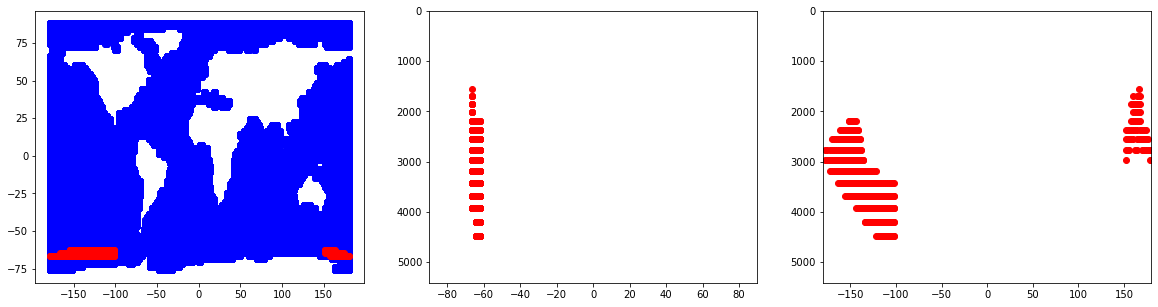

AAIW


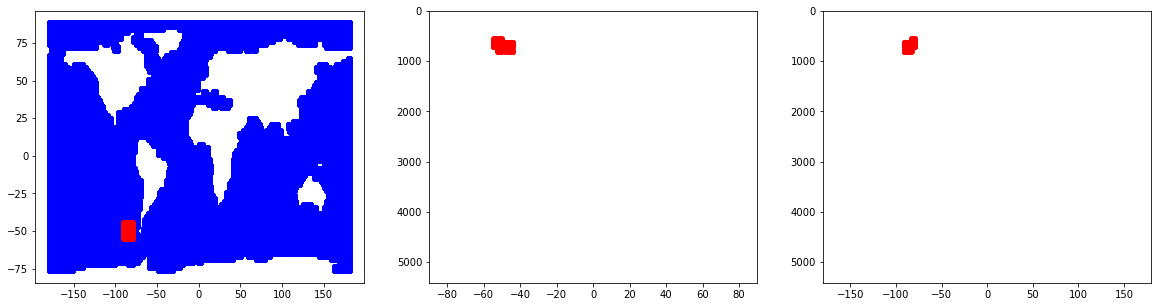

ENPCW


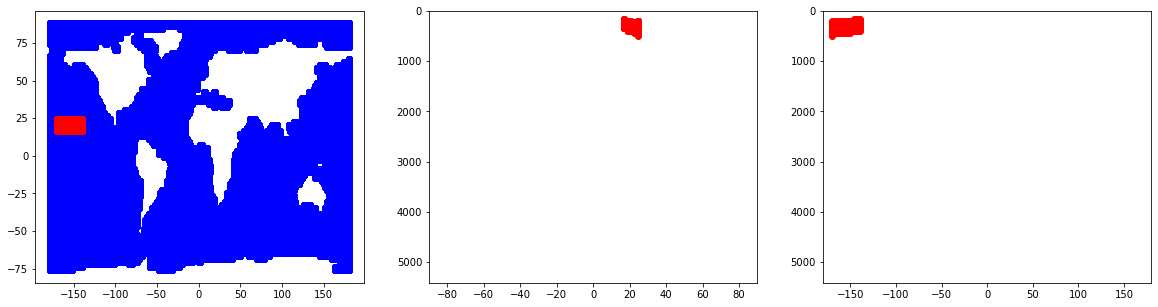

ESSW


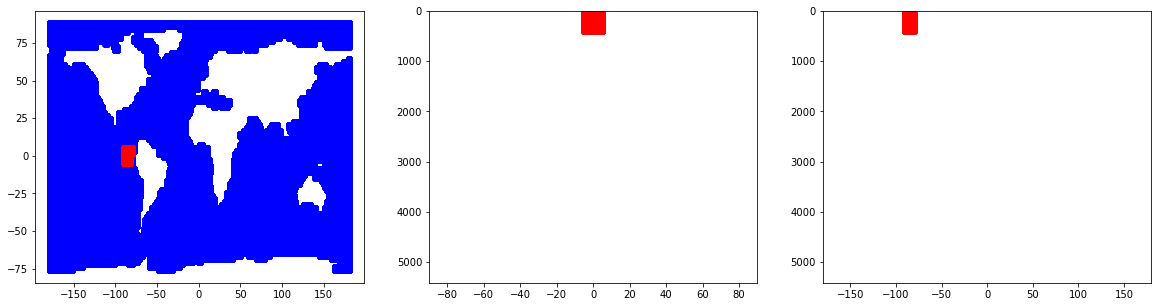

EqIW


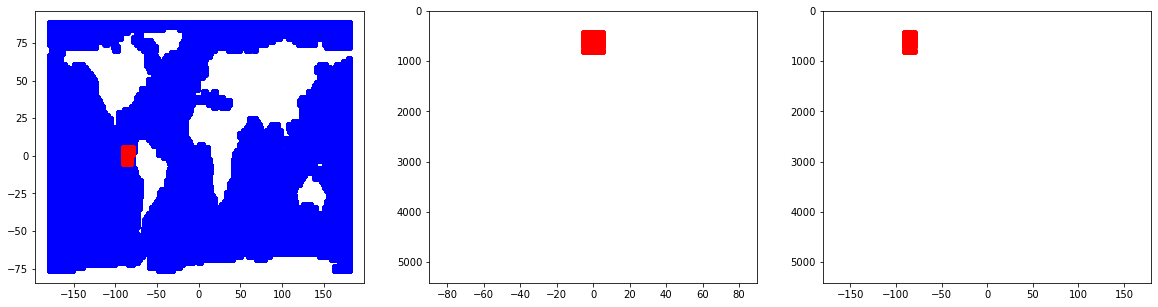

LCDW


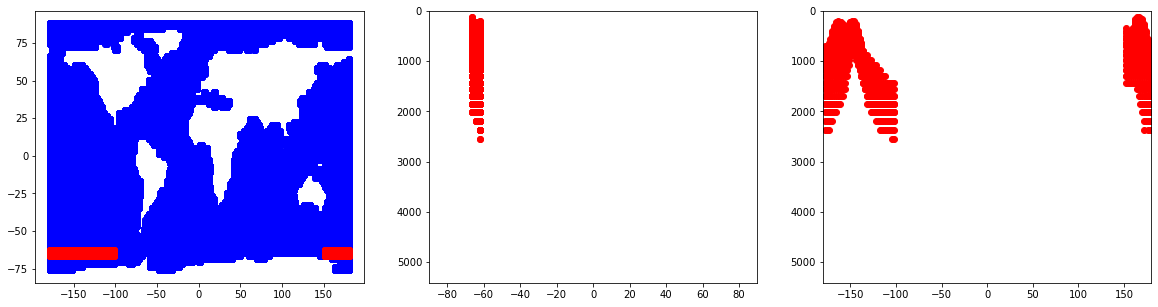

NPIW


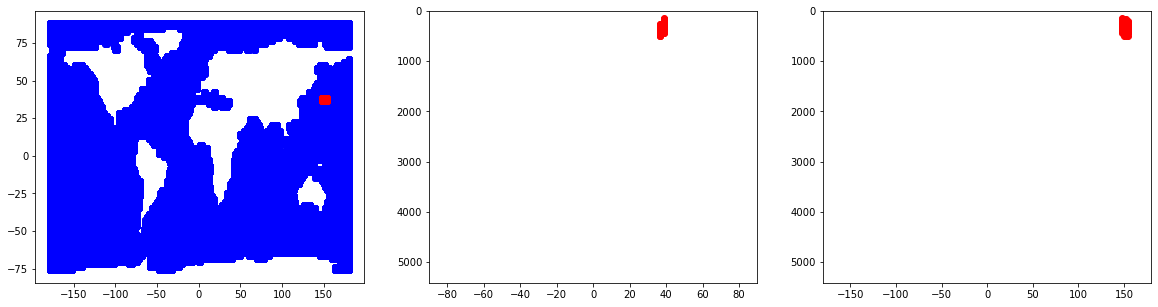

PDW


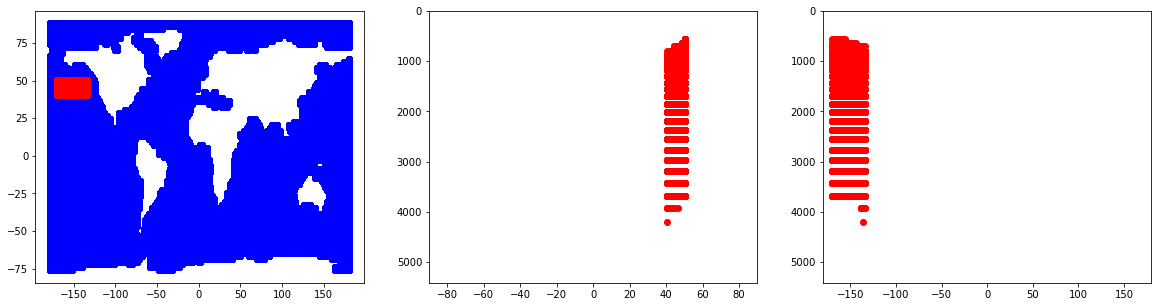

PSUW


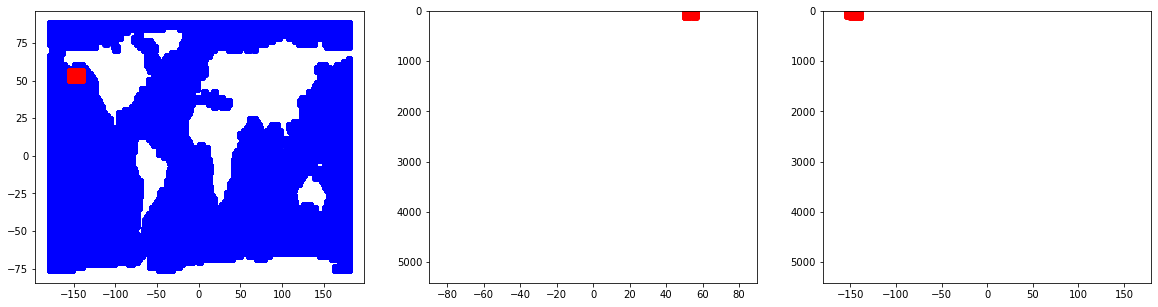

SPCW


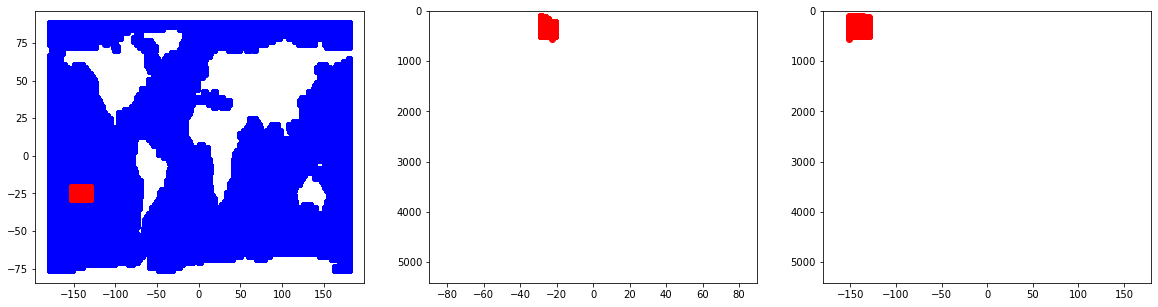

UCDW


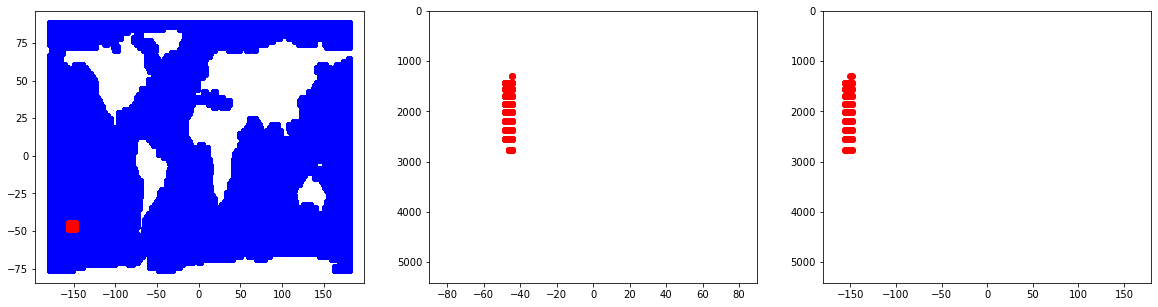

In [38]:
endmem_names = sorted(endmem_to_idxs.keys())

for endmem in endmem_names:
    print(endmem)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

    plt.sca(ax[0])
    #first make a scatterplot of the water surface
    plt.scatter(ulon_ocnvec,
            ulat_ocnvec, color="blue")
    #now overlay the endmember
    #handles.append(
    plt.scatter(
        ulon_ocnvec[np.array(list(endmem_to_idxs[endmem]))],
        ulat_ocnvec[np.array(list(endmem_to_idxs[endmem]))],
        color="red")
    #)

    plt.sca(ax[1])
    plt.scatter(
        ulat_ocnvec[np.array(list(endmem_to_idxs[endmem]))],
        depth_ocnvec[np.array(list(endmem_to_idxs[endmem]))],
        color="red")
    plt.xlim(-90,90)
    plt.ylim(max(depth_ocnvec),0)

    plt.sca(ax[2])
    plt.scatter(
        ulon_ocnvec[np.array(list(endmem_to_idxs[endmem]))],
        depth_ocnvec[np.array(list(endmem_to_idxs[endmem]))],
        color="red")
    plt.xlim(-180,180)
    plt.ylim(max(depth_ocnvec),0)
    plt.show()


## Load the GP02 data

We load the GP02 data so that we can compare how the predictions from OCIM along the GP02 transect compare to the empirical measurements on the GP02 cruise. We focus on intermediate and deep waters here.

In [39]:
def download_and_load_GP02_data(station_to_tc_cutoffs_url="https://github.com/nitrogenlab/GP15_watermassanalysis/blob/0a64ed0faca01701cf6c84d09365abc706594e2c/GP02_station_to_tc_cutoffs.json",
                                cutoffs_file_name="GP02_station_to_tc_cutoffs.json"):
    return load_GP02_data(station_to_tc_cutoffs_url=station_to_tc_cutoffs_url,
                          cutoffs_file_name=cutoffs_file_name)
def load_GP02_data(station_to_tc_cutoffs_url,
                   cutoffs_file_name):

    download_file(url=station_to_tc_cutoffs_url, file_name=cutoffs_file_name)
    station_to_tcstartend = json.loads(open(cutoffs_file_name).read())

    import pandas as pd
    
    colnames_subset = ['Cruise', 'Station', 'Latitude [degrees_north]', 'Longitude [degrees_east]', 'yyyy-mm-ddThh:mm:ss.sss', 
                       'DEPTH [m]', 'CTDPRS_T_VALUE_SENSOR [dbar]', 'CTDTMP_T_VALUE_SENSOR [deg C]', 'CTDSAL_D_CONC_SENSOR [pss-78]',
                   'QV:SEADATANET','OXYGEN_D_CONC_BOTTLE [umol/kg]','QV:SEADATANET','SILICATE_D_CONC_BOTTLE [umol/kg]',
                   'QV:SEADATANET', 'PHOSPHATE_D_CONC_BOTTLE [umol/kg]', 'QV:SEADATANET']
    #'NITRATE_D_CONC_BOTTLE [umol/kg]', 'QV:SEADATANET', remove because not nitrate data from this cruise

    GP02_df = pd.read_csv("/Users/rianlawrence/Downloads/ocim_dir/bottleGP02_IDP2021_v2_GEOTRACES_Seawater_Discrete_Sample_Data_v2_wlG854xv.csv", na_values = -9999)[colnames_subset]
   
    GP02_df = GP02_df.assign(Station=GP02_df['Station'].str.replace(r'\D', ''))
    GP02_df['Station'] = GP02_df['Station'].astype(int)

    GP02_columns =['cruise', 'stnnbr',"lat", 'lon', 'year', 'depth',
             'CTD pressure', 'temperature', 'salinity', "salinity flag", 
             'oxygen', "oxygen flag", 'silicate', "silicate flag",'phosphate', "phosphate flag"] 
    #no nitrate, so removed 'nitrate', "nitrate flag", 
    GP02_df.columns= GP02_columns

    absolute_salinity = np.array((gsw.SA_from_SP(SP=GP02_df["salinity"],
              p=GP02_df["CTD pressure"],
              lon=GP02_df["lon"],
              lat=GP02_df["lat"])))
    GP02_df["absolute_salinity"] = absolute_salinity

    conservative_temp = gsw.CT_from_t(SA=absolute_salinity,
               t=np.array(GP02_df["temperature"]),
               p=np.array(GP02_df["CTD pressure"]))
    GP02_df["conservative_temp"] = conservative_temp

    potential_temp = gsw.pt_from_CT(SA=absolute_salinity,
                                CT=conservative_temp)
    GP02_df["potential_temp"] = potential_temp

    sig0 = gsw.rho(SA=np.array(absolute_salinity), CT=np.array(conservative_temp), p=0) - 1000
    GP02_df["sigma0"] = sig0

    z = gsw.z_from_p(p=np.array(GP02_df["CTD pressure"]), lat=np.array(GP02_df["lat"]))
    depth = -z #https://github.com/TEOS-10/python-gsw/blob/7d6ebe8114c5d8b4a64268d36100a70e226afaf6/gsw/gibbs/conversions.py#L577
    GP02_df["Depth"] = depth
    
    print("Rows in gp02 datafile:",len(GP02_df))
    GP02_df = GP02_df.dropna()
    print("Rows without NA values:",len(GP02_df))

    GP02_intermediateanddeep = GP02_df[GP02_df.apply(
          lambda x: x['Depth'] >
                    station_to_tcstartend[
                      str(float(x['stnnbr']))]['depth_cutoffs'][1], axis=1)] 

    GP02_thermocline =  GP02_df[GP02_df.apply(
            lambda x: (x['Depth'] > station_to_tcstartend[
                         str(float(x['stnnbr']))]['depth_cutoffs'][0])
                  and (x['Depth'] < station_to_tcstartend[
                         str(float(x['stnnbr']))]['depth_cutoffs'][1]), axis=1)]

    return GP02_df, GP02_intermediateanddeep, GP02_thermocline


def download_file(url, file_name):
        import os
        os.system("wget "+url+" -O "+file_name)


def load_interanddeep_endmember_df(
        df_url,
        df_file_name="GP15_intermediateanddeep.csv"):
    download_file(url=df_url, file_name=df_file_name)
    endmember_df = pd.read_csv(df_file_name)
    return endmember_df


def get_pyompa_soln(obs_df, endmember_df_touse,
                     param_names=None, param_weightings=None,
                     convertedparam_groups=None, usagepenalty=None,
                     endmember_name_column="watermass_name",
                     batch_size=100):

    if param_names is None:
        param_names = settingdefaults.PARAM_NAMES 
        print("param_names is None; using defaults:")
        print(param_names)

    if param_weightings is None:
        param_weightings = settingdefaults.PARAM_WEIGHTINGS
        print("param_weightings is None; using defaults:")
        print(param_weightings)

    if convertedparam_groups is None:
        convertedparam_groups=settingdefaults.CONVERTEDPARAM_GROUPS
        print("convertedparam_groups is None; using defaults")
        print(convertedparam_groups)

    if usagepenalty is None:
        usagepenalty = settingdefaults.USAGE_PENALTY
        print("usagepenalty is None; using defaults")
        print(usagepenalty)

    return pyompa.OMPAProblem(
              obs_df=obs_df,
              endmembername_to_usagepenaltyfunc=usagepenalty,
              param_names=param_names,
              param_weightings=param_weightings,
              convertedparam_groups=convertedparam_groups).solve(
                  endmember_df_touse,
                  endmember_name_column=endmember_name_column,
                  batch_size=batch_size)

In [40]:
GP02_df, GP02_intermediateanddeep, GP02_thermocline = download_and_load_GP02_data(
    station_to_tc_cutoffs_url="https://github.com/nitrogenlab/GP15_watermassanalysis/blob/0a64ed0faca01701cf6c84d09365abc706594e2c/GP02_station_to_tc_cutoffs.json")
#del GP02_df, GP02_thermocline

Rows in gp02 datafile: 3851
Rows without NA values: 800


In [41]:
print("Rows in gp02 datafile:",len(GP02_df))
test = GP02_df.dropna()
print("Rows without NA values:",len(test))
p = GP02_df["phosphate"].dropna()
print("Rows without NA phosphate values:",len(p))
si = GP02_df["silicate"].dropna()
print("Rows without NA silicate values:",len(si))
ox = GP02_df["oxygen"].dropna()
print("Rows without NA oxygen values:",len(ox))
#oxygen is limiting factor here with only 845 data points
temp = GP02_df["conservative_temp"].dropna()
print("Rows without NA temp values:",len(temp))
sal = GP02_df["absolute_salinity"].dropna()
print("Rows without NA salinity values:",len(sal))

Rows in gp02 datafile: 800
Rows without NA values: 800
Rows without NA phosphate values: 800
Rows without NA silicate values: 800
Rows without NA oxygen values: 800
Rows without NA temp values: 800
Rows without NA salinity values: 800


### Index GP02 data by OCIM gridboxes

We can reuse the code from when we read the GLODAP data into OCIM gridboxes

In [42]:
gp15_obs_grid, gp15_obsgrid_idxmapping =\
  prepare_obsgrid_from_df(
    df=GP02_intermediateanddeep,
    wz_ticks=ocim_wz_ticks, ulon_ticks=ocim_ulon_ticks,
    ulat_ticks=ocim_ulat_ticks,
    depth_key="Depth", longitude_key="lon", latitude_key="lat",
    keys_to_record=["conservative_temp", "absolute_salinity", "silicate"],
    return_idx_mapping=True)

Warning! (125.05056219701946, 141.51601000000002, 37.5845) is closest to land gridbox (118.95504902975814, 142.0, 38.57142857142857) so mapping to (118.95504902975814, 144.0, 38.57142857142857) gridbox instead
Warning! (3931.0511409967135, 143.882, 37.8144) is closest to land gridbox (3933.1566119176437, 144.0, 38.57142857142857) so mapping to (3674.983119979456, 144.0, 38.57142857142857) gridbox instead
Warning! (4419.0563346113695, 143.882, 37.8144) is closest to land gridbox (4486.579388154615, 144.0, 38.57142857142857) so mapping to (4486.579388154615, 146.0, 38.57142857142857) gridbox instead
Warning! (4906.1233526608385, 143.882, 37.8144) is closest to land gridbox (4782.419521734046, 144.0, 38.57142857142857) so mapping to (4486.579388154615, 146.0, 38.57142857142857) gridbox instead
Warning! (5390.253804487159, 143.882, 37.8144) is closest to land gridbox (5413.834403016414, 144.0, 38.57142857142857) so mapping to (4486.579388154615, 146.0, 38.57142857142857) gridbox instead
Wa

### Compute average GP02 data in OCIM gridboxes

As before, we reuse the code we wrote for doing this on GLODAP data

In [43]:
#Get the mean conservative temperature, absolute salinity and silicate
gp15_mean_ctemp_ocnvec = get_mean_from_obs_grid(
    attr="conservative_temp",
    obs_grid=gp15_obs_grid).ravel()[ocnmask.ravel()]
gp15_mean_asbsal_ocnvec = get_mean_from_obs_grid(
    attr="absolute_salinity",
    obs_grid=gp15_obs_grid).ravel()[ocnmask.ravel()]
gp15_mean_silicate_ocnvec = get_mean_from_obs_grid(
    attr="silicate",
    obs_grid=gp15_obs_grid).ravel()[ocnmask.ravel()]

Delete objects to save memory

In [44]:
del gp15_obs_grid
gc.collect()

69

## Compute the distributions at steady-state

We compute the distributions of tracers and end-members at steady state, treating the end-members as sources for the rest of the ocean

### Prepare code to compute steady-state distributions

There are some bugs associated with Google Colab's version of scipy in terms of how it interfaces with umfpack. To fix this, I have ported over an alternative versions of the relevant functions from https://github.com/scipy/scipy/pull/11453.

I have also modified the functions to use the METIS ordering for the LU decomposition, since the default umfpack ordering runs out of memory without this.

In [45]:
#see https://github.com/scipy/scipy/pull/11453

def _get_umf_family(A):
    """Get umfpack family string given the sparse matrix dtype."""
    _families = {
        (np.float64, np.int32): 'di',
        (np.complex128, np.int32): 'zi',
        (np.float64, np.int64): 'dl',
        (np.complex128, np.int64): 'zl'
    }

    f_type = np.sctypeDict[A.dtype.name]
    i_type = np.sctypeDict[A.indices.dtype.name]

    try:
        family = _families[(f_type, i_type)]

    except KeyError:
        msg = 'only float64 or complex128 matrices with int32 or int64' \
            ' indices are supported! (got: matrix: %s, indices: %s)' \
            % (f_type, i_type)
        raise ValueError(msg)

    # See gh-8278. Considered converting only if
    # A.shape[0]*A.shape[1] > np.iinfo(np.int32).max,
    # but that didn't always fix the issue.
    family = family[0] + "l"
    A_new = copy.copy(A)
    A_new.indptr = np.array(A.indptr, copy=False, dtype=np.int64)
    A_new.indices = np.array(A.indices, copy=False, dtype=np.int64)

    return family, A_new


def get_umf_context(A):
    if is_pydata_spmatrix(A):
        A = A.to_scipy_sparse().tocsc()

    if not isspmatrix_csc(A):
        A = csc_matrix(A)
        warn('splu requires CSC matrix format', SparseEfficiencyWarning)

    A = A.asfptype()  # upcast to a floating point format

    if A.dtype.char not in 'dD':
        raise ValueError("convert matrix data to double, please, using"
              " .astype(), or set linsolve.useUmfpack = False")

    umf_family, A = _get_umf_family(A)
    umf = umfpack.UmfpackContext(umf_family)
    #METIS ordering ends up taking up MUCH less memory!
    umf.control[umfpack.UMFPACK_ORDERING] = umfpack.UMFPACK_ORDERING_METIS

    #see 'alternative routines' section of the UMFPACK user guide
    # page 17 describes the orderings
    #Also see documentation for umfpackcontext:
    # https://github.com/scikit-umfpack/scikit-umfpack/blob/a2102ef92f4dd060138e72bb5d7c444f8ec49cbc/scikits/umfpack/umfpack.py#L114

    return umf, A


#creating a fixed version of factorize
def fixed_factorize(A):
    umf, A = get_umf_context(A)
    # Make LU decomposition.
    umf.numeric(A)
    def solve(b):
        return umf.solve(umfpack.UMFPACK_A, A, b, autoTranspose=True)
    return solve


#create a fixed version of solve
def fixed_solve(A, b):
    umf, A = get_umf_context(A)

    return umf.linsolve(umfpack.UMFPACK_A, A, b,
                         autoTranspose=True)

    return solve


Now we are ready to define the function to get the steady-state tracer concentrations by solving the linear system.

In [46]:

class GetSteadyStateTracerConcsViaMatrixSolve(object):

    """
    T: the 2d transport matrix
    source_idxs: the set of indexes to designate as source gridboxes
    """
    def __init__(self, T, source_idxs, tau=None):
        print(datetime.now(), "Prepping solver")
        self.tau = tau
        to_factorize = self.get_tofactorize(T=T, source_idxs=source_idxs)
        #self.find_conditionnumber(mat=to_factorize)
        #Don't invert the matrix!
        # https://www.johndcook.com/blog/2010/01/19/dont-invert-that-matrix/
        self.solver = fixed_factorize(to_factorize)
        print(datetime.now(), "solver prepped")

    @staticmethod
    def find_conditionnumber(mat):
        print(datetime.now(),"Computing A A^t")
        AAt = mat @ mat.transpose()
        print(datetime.now(),"Getting largest eigenvalue")
        largest_eig = scipy.sparse.linalg.eigsh(A=AAt, k=1, which='LM',
                                                return_eigenvectors=False)
        print(datetime.now(), largest_eig)
        print(datetime.now(),"Getting smallest eigenvalue")
        smallest_eig = scipy.sparse.linalg.eigsh(A=AAt, k=1, which='SM',
                                                 sigma=0,
                                                 return_eigenvectors=False)
        print(datetime.now(), smallest_eig)
        print("Ratio:", largest_eig/smallest_eig)

    #source_vecs should be set to the empirically-determined concentration
    # of the tracer for the source gridboxes, and should be 0 for all
    # non-source gridboxes.
    def __call__(self, source_vecs):
        print(datetime.now(), "Calling solver")
        if (self.tau is not None):
            return self.solver(-source_vec/self.tau)
        else:
            return self.solver(-source_vec)
        print(datetime.now(), "Solver called")

    def get_tofactorize(self, T, source_idxs):
        #Return the matrix that needs to be factorized
        # [(I - M)T - M] for the tau=None case
        # (T - M/tau) for the other case
        m_vec = np.zeros(T.shape[0])
        m_vec[source_idxs] = 1.0
        M = scipy.sparse.diags(m_vec)
        if (self.tau is not None):
            return csc_matrix(T - M/self.tau)
        else:
            I_minus_M = scipy.sparse.diags(1 - m_vec)
            return csc_matrix(I_minus_M@T - M)



### Instantiate the solver

Instantiate a solver that's appropriate for the source indices we are using in this case

In [47]:
source_idxs = np.array(list(set(np.concatenate(
                  [list(x) for x in endmem_to_idxs.values()], axis=0))))

solver = GetSteadyStateTracerConcsViaMatrixSolve(
            T=base_transport,
            source_idxs=source_idxs,
            #tau=None,
            tau=(1.0/(60*60*24*365))
            )

2023-09-04 12:29:46.441097 Prepping solver
2023-09-04 12:35:55.607459 solver prepped


/Users/rianlawrence/opt/anaconda3/lib/python3.8/site-packages/scikits/umfpack/umfpack.py:563: UmfpackWarning: Singular matrix
  warnings.warn('Singular matrix', UmfpackWarning)


### Compute the steady-state tracer distributions

With the solver instantiated, we can compute the expected tracer concentrations based on the OCIM fluxes, assuming that the sources for the tracers are the defined end-members

On  absolute salinity
2023-09-04 12:35:55.797576 Calling solver


/Users/rianlawrence/opt/anaconda3/lib/python3.8/site-packages/scikits/umfpack/umfpack.py:712: UmfpackWarning: Zeroing nan and inf entries...
  warnings.warn('Zeroing nan and inf entries...', UmfpackWarning)
/Users/rianlawrence/opt/anaconda3/lib/python3.8/site-packages/scikits/umfpack/umfpack.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  econd = 1.0 / self.info[UMFPACK_RCOND]
/Users/rianlawrence/opt/anaconda3/lib/python3.8/site-packages/scikits/umfpack/umfpack.py:721: UmfpackWarning: (almost) singular matrix! (estimated cond. number: inf)
  warnings.warn(msg, UmfpackWarning)


On  conservative temp
2023-09-04 12:36:08.551456 Calling solver
On  silicate
2023-09-04 12:36:09.303105 Calling solver


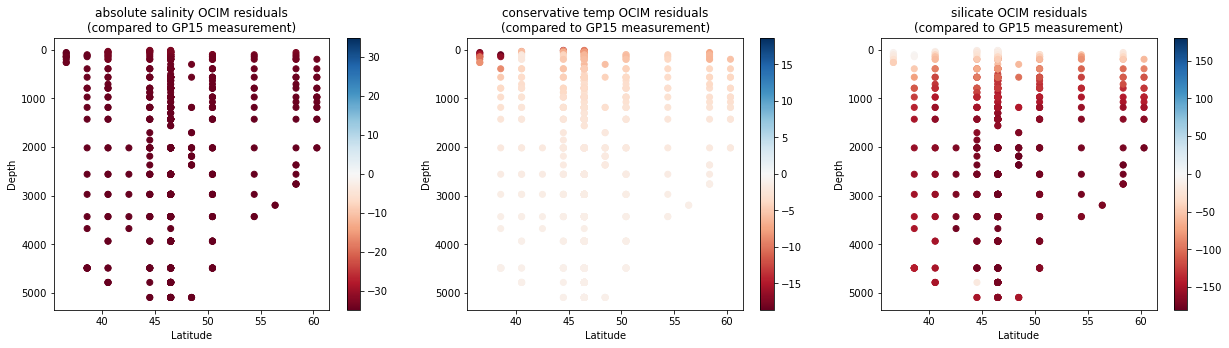

In [48]:
tracers = [
    ("absolute salinity", woa18_mean_abssal_ocnvec, gp15_mean_asbsal_ocnvec),
    ("conservative temp", woa18_mean_ctemp_ocnvec, gp15_mean_ctemp_ocnvec),
    ("silicate", woa18_mean_silicate_ocnvec, gp15_mean_silicate_ocnvec)
]

gp15_idxs = ocnvec_mapping[tuple(gp15_obsgrid_idxmapping)]
#gp15_idxs = np.nonzero((np.isnan(gp15_mean_ctemp_ocnvec)==False))

fig, ax = plt.subplots(nrows=1, ncols=len(tracers),
                       figsize=(len(tracers)*7, 5))

tracer_to_ocim_residuals = {}

for i,(tracer_name, woa18_tracer_vals, gp15_tracer_vals) in enumerate(tracers):
    print("On ",tracer_name)
    #source vec has to be zero at all entries that are not sources. At
    # source entries, it should equal the empirically measured values
    source_vec = np.zeros(base_transport.shape[0])
    source_vec[source_idxs] = woa18_tracer_vals[source_idxs]
    steady_state_soln = solver(source_vec)

    plt.sca(ax[i])
    #Compute the residual with respect to the GP15 observation
    residuals = (steady_state_soln[gp15_idxs] - gp15_tracer_vals[gp15_idxs])
    tracer_to_ocim_residuals[tracer_name] = residuals
    plt.scatter(
        ulat_ocnvec[gp15_idxs],
        depth_ocnvec[gp15_idxs],
        c=residuals,
        vmin=-np.max(np.abs(residuals)), vmax=np.max(np.abs(residuals)),
        cmap="RdBu"
    )
    plt.ylim(plt.ylim()[1], plt.ylim()[0])
    plt.ylabel("Depth")
    plt.xlabel("Latitude")
    plt.title(tracer_name+" OCIM residuals\n(compared to GP15 measurement)")
    plt.colorbar()

plt.show()

### Compute the steady-state end-member distributions

Eeach end-member is like a tracer that has a value of 1 at all source gridboxes occupied by the end-member, and a value of 0 at all source gridboxes that are not occupied by the end-member. We will also define an end-member called "_ALL" that is the union of all endmembers in order to diagnose whether we may have missing end-members (if there are no end-members missing, then the end-member fractions should sum up close to 1 everywhere)

We will plot each end-member both on a fixed 0-1 scale (bottom) and on a relative scale that is adjusted to the minimum/maximum concentration of that end-member. The latter allows us to see the end-member distribution more clearly, while the former allows us to compare results for different end-members.

On: AABW
2023-09-04 12:36:10.614972 Calling solver
Globally:
max val: 0.0
min val: 0.0
Along GP02:
max val: 0.0
min val: 0.0
On: AAIW
2023-09-04 12:36:11.191066 Calling solver
Globally:
max val: 0.0
min val: 0.0
Along GP02:
max val: 0.0
min val: 0.0
On: ENPCW
2023-09-04 12:36:11.741792 Calling solver
Globally:
max val: 0.0
min val: 0.0
Along GP02:
max val: 0.0
min val: 0.0
On: ESSW
2023-09-04 12:36:12.306959 Calling solver
Globally:
max val: 0.0
min val: 0.0
Along GP02:
max val: 0.0
min val: 0.0
On: EqIW
2023-09-04 12:36:12.853092 Calling solver
Globally:
max val: 0.0
min val: 0.0
Along GP02:
max val: 0.0
min val: 0.0
On: LCDW
2023-09-04 12:36:13.364353 Calling solver
Globally:
max val: 0.0
min val: 0.0
Along GP02:
max val: 0.0
min val: 0.0
On: NPIW
2023-09-04 12:36:13.944298 Calling solver
Globally:
max val: 0.0
min val: 0.0
Along GP02:
max val: 0.0
min val: 0.0
On: PDW
2023-09-04 12:36:14.479859 Calling solver
Globally:
max val: 0.0
min val: 0.0
Along GP02:
max val: 0.0
min val: 0.0


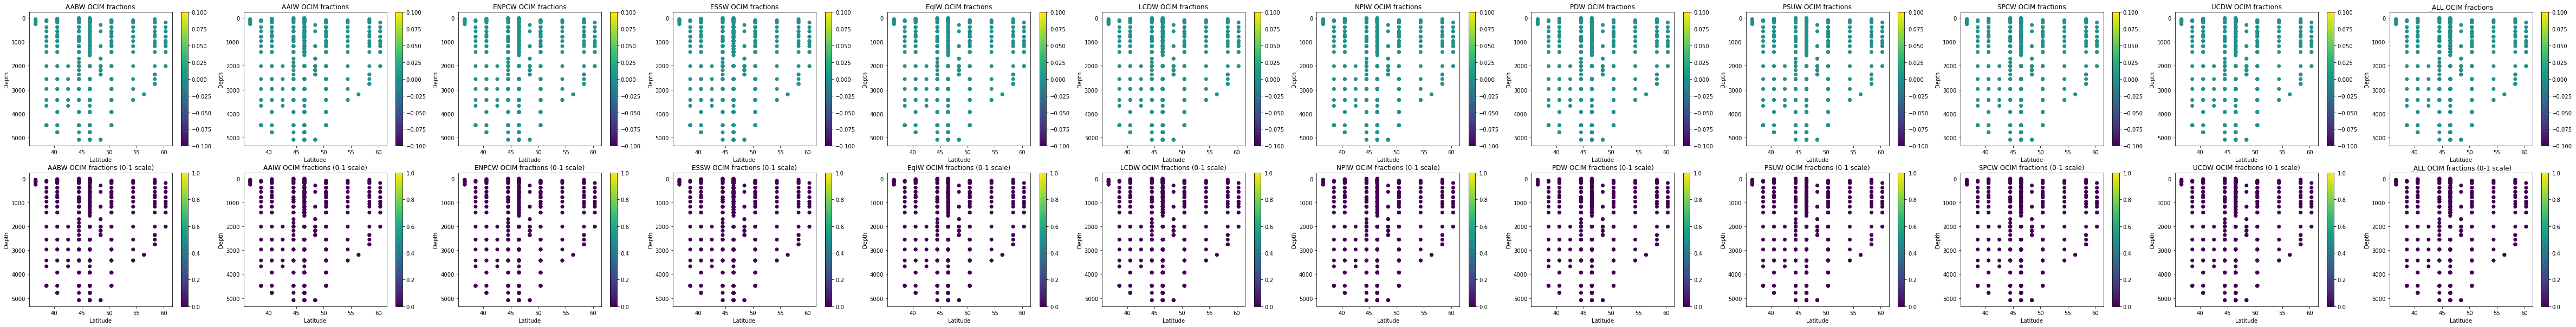

In [49]:
#find steady-state distributions

endmem_to_idxs["_ALL"] = source_idxs

fig, ax = plt.subplots(nrows=2, ncols=len(endmem_to_idxs),
                       figsize=(len(endmem_to_idxs)*7, 10))

endmemname_to_ocimfracs = {}

for i, endmem in enumerate(sorted(endmem_to_idxs.keys())):
    print("On:", endmem)
    endmem_idxs = np.array(list(endmem_to_idxs[endmem]))
    source_vec = np.zeros(base_transport.shape[0])
    source_vec[endmem_idxs] = 1.0
    steady_state_soln = solver(source_vec)

    endmemname_to_ocimfracs[endmem] = steady_state_soln[gp15_idxs]

    print("Globally:")
    print("max val:",np.max(steady_state_soln))
    print("min val:",np.min(steady_state_soln))
    print("Along GP02:")
    print("max val:",np.max(steady_state_soln[gp15_idxs]))
    print("min val:",np.min(steady_state_soln[gp15_idxs]))
    #If the transport matrix has no off-diagonal negative entries, then
    # numerical errors can lead to frac values less than 0 or more than 1; get
    # rid of this
    #steady_state_soln = np.maximum(0, np.minimum(steady_state_soln, 1.0))

    plt.sca(ax[0,i])
    plt.scatter(
        ulat_ocnvec[gp15_idxs],
        depth_ocnvec[gp15_idxs],
        c=steady_state_soln[gp15_idxs]
    )
    plt.ylim(plt.ylim()[1], plt.ylim()[0])
    plt.ylabel("Depth")
    plt.xlabel("Latitude")
    plt.title(endmem+" OCIM fractions")
    plt.colorbar()

    plt.sca(ax[1,i])
    plt.scatter(
        ulat_ocnvec[gp15_idxs],
        depth_ocnvec[gp15_idxs],
        c=steady_state_soln[gp15_idxs],
        vmin=0.0, vmax=1.0
    )
    plt.ylim(plt.ylim()[1], plt.ylim()[0])
    plt.ylabel("Depth")
    plt.xlabel("Latitude")
    plt.title(endmem+" OCIM fractions (0-1 scale)")
    plt.colorbar()

plt.show()

#save endmemname_to_ocimfracs for use in other notebooks
np.save("endmemname_to_ocimfracs", endmemname_to_ocimfracs)

# Perform OMP analysis for the GP02 transect

We will use the pyompa implementation of OMP, as this has several additional features/improvements over traditional OMP analysis.

## Download and load pyompa end-member definitions

We focus on intermediate and deep waters here. We will use the gp02wma package.

In [50]:
interanddeep_endmember_df = pandas.read_csv("/Users/rianlawrence/Downloads/ocim_dir/GP15_intermediateanddeep_endmemberswithsubtypes.csv")
#interanddeep_endmember_df = GP02wma.load_interanddeep_endmember_df(
    #df_url="https://raw.githubusercontent.com/nitrogenlab/GP15_watermassanalysis/main/GP15_intermediateanddeep_endmemberswithsubtypes.csv",
    #df_file_name="GP15_intermediateanddeep_endmemberswithsubtypes.csv")

## Run pyompa

We use the settings in the GP02wma package

In [51]:
pyompa_soln = GP02wma.get_pyompa_soln(
    obs_df=GP02_intermediateanddeep,
    endmember_df_touse=interanddeep_endmember_df)

param_names is None; using defaults:
['conservative_temp', 'absolute_salinity', 'silicate', 'phosphate', 'oxygen']
param_weightings is None; using defaults:
{'conservative_temp': 56.0, 'absolute_salinity': 80.0, 'silicate': 3.0, 'phosphate': 5.0, 'oxygen': 1.0, 'NO': 1.0, 'PO': 0.5}
convertedparam_groups is None; using defaults
usagepenalty is None; using defaults
{'ENPCW_*': <pyompa.endmemberpenaltyfunc.GeneralPenaltyFunc object at 0x7fe8a40ceac0>, 'SPCW_*': <pyompa.endmemberpenaltyfunc.GeneralPenaltyFunc object at 0x7fe8a40cedc0>, 'PSUW_*': <pyompa.endmemberpenaltyfunc.GeneralPenaltyFunc object at 0x7fe8a40d5040>, 'ESSW_*': <pyompa.endmemberpenaltyfunc.GeneralPenaltyFunc object at 0x7fe8a40d51f0>, 'EqIW_*': <pyompa.endmemberpenaltyfunc.GeneralPenaltyFunc object at 0x7fe8a40d5490>, 'LCDW_*': <pyompa.endmemberpenaltyfunc.GeneralPenaltyFunc object at 0x7fe8a40d5730>, 'AAIW_*': <pyompa.endmemberpenaltyfunc.GeneralPenaltyFunc object at 0x7fe8a40d59d0>, 'NPIW_*': <pyompa.endmemberpenaltyfu

## Plot pyompa base solution

Plot the residuals

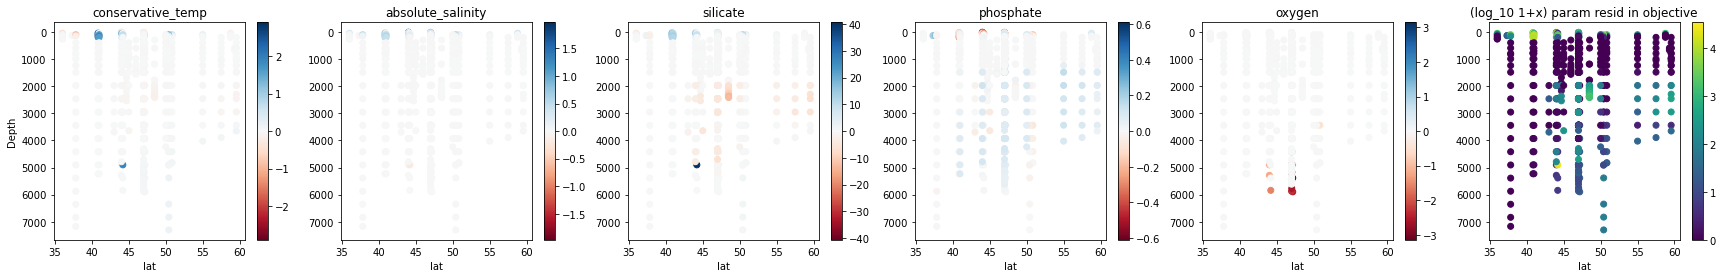

In [52]:
from pyompa import plot_ompasoln_residuals
plot_ompasoln_residuals(pyompa_soln, xaxis_colname="lat", yaxis_colname="Depth")

Plot the endmember fractions in the "base" solution (this is just one solution, without the uncertainty analysis)

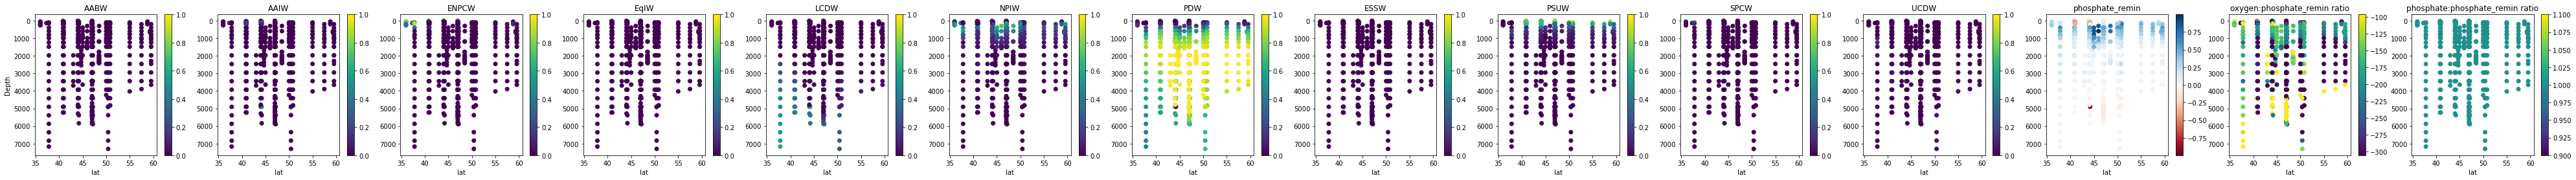

In [53]:
from pyompa import plot_ompasoln_endmember_fractions
plot_ompasoln_endmember_fractions(pyompa_soln, xaxis_colname="lat",
                                  yaxis_colname="Depth")

# Use OCIM to refine the OMPA results

Our pyompa system is underdetermined, i.e. the solution is ambiguous. We can use OCIM to select a specific solution that achieves similar residuals to the best pyompa solution and also matches the OCIM solution as closely as possible

In [54]:
from importlib import reload
import pyompa
reload(pyompa.endmemberpenaltyfunc)
reload(pyompa)

<module 'pyompa' from '/Users/rianlawrence/opt/anaconda3/lib/python3.8/site-packages/pyompa/__init__.py'>

In [55]:
#set up the matrices needed for enforcing the penalties
obj_weights = np.zeros((
    len(pyompa_soln.endmembername_to_indices),
    len(pyompa_soln.endmember_names) + pyompa_soln.ompa_problem.num_converted_variables))
target_endmem_fracs = np.zeros((len(gp15_idxs),
                                len(pyompa_soln.endmembername_to_indices)))

for endmemberoverallidx, (endmembername, endmember_idxs) in enumerate(pyompa_soln.endmembername_to_indices.items()):
    obj_weights[endmemberoverallidx, endmember_idxs] = 1.0
    target_endmem_fracs[:, endmemberoverallidx] =\
      endmemname_to_ocimfracs[endmembername]

#compute the solution - setting resids to 0 constrains them to be no worse
# than what was obtained in the optimal pyompa soln
#order of "conservative_temp", "absolute_salinity","silicate", "nitrate", "phosphate", "oxygen"
#assumed for 0.001, 0.004, 0.4, 0.1, 0.015, 0.2; removing 0.1
max_resids = 0.0*np.array([0.001, 0.004, 0.4, 0.015, 0.2])
ocim_pyompa_soln = pyompa.ompacore.OMPASoln.core_quantify_ambiguity_via_residual_limits(
    self=pyompa_soln, obj_weights=obj_weights,
    max_resids=max_resids, retain_original_penalties=True,
    target_endmem_fracs=target_endmem_fracs,
    verbose=True, max_iter=1000000)

Found match between ENPCW_0 and prefix ENPCW_*
Found match between ENPCW_1 and prefix ENPCW_*
Found match between SPCW_0 and prefix SPCW_*
Found match between SPCW_1 and prefix SPCW_*
Found match between PSUW_0 and prefix PSUW_*
Found match between PSUW_1 and prefix PSUW_*
Found match between ESSW_0 and prefix ESSW_*
Found match between ESSW_1 and prefix ESSW_*
Found match between EqIW_0 and prefix EqIW_*
Found match between EqIW_1 and prefix EqIW_*
Found match between LCDW_0 and prefix LCDW_*
Found match between LCDW_1 and prefix LCDW_*
Found match between AAIW_0 and prefix AAIW_*
Found match between AAIW_1 and prefix AAIW_*
Found match between NPIW_0 and prefix NPIW_*
Found match between NPIW_1 and prefix NPIW_*
Found match between NPIW_2 and prefix NPIW_*
Found match between UCDW_0 and prefix UCDW_*
Found match between AABW_0 and prefix AABW_*
On obs 0 out of 614
On obs 1 out of 614
On obs 2 out of 614
On obs 3 out of 614
On obs 4 out of 614
On obs 5 out of 614
On obs 6 out of 614
O

/Users/rianlawrence/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


On obs 88 out of 614
On obs 89 out of 614
On obs 90 out of 614
On obs 91 out of 614
On obs 92 out of 614
On obs 93 out of 614
On obs 94 out of 614
On obs 95 out of 614
On obs 96 out of 614
On obs 97 out of 614
On obs 98 out of 614
On obs 99 out of 614
On obs 100 out of 614
On obs 101 out of 614
On obs 102 out of 614
On obs 103 out of 614
On obs 104 out of 614
On obs 105 out of 614
On obs 106 out of 614
On obs 107 out of 614
On obs 108 out of 614
On obs 109 out of 614
On obs 110 out of 614
On obs 111 out of 614
On obs 112 out of 614
On obs 113 out of 614
On obs 114 out of 614
On obs 115 out of 614
On obs 116 out of 614
On obs 117 out of 614
On obs 118 out of 614
On obs 119 out of 614
On obs 120 out of 614
On obs 121 out of 614
On obs 122 out of 614
On obs 123 out of 614
On obs 124 out of 614
On obs 125 out of 614
On obs 126 out of 614
On obs 127 out of 614
On obs 128 out of 614
On obs 129 out of 614
On obs 130 out of 614
On obs 131 out of 614
On obs 132 out of 614
On obs 133 out of 614


On obs 296 out of 614
On obs 297 out of 614
On obs 298 out of 614
On obs 299 out of 614
On obs 300 out of 614
On obs 301 out of 614
On obs 302 out of 614
On obs 303 out of 614
On obs 304 out of 614
On obs 305 out of 614
On obs 306 out of 614
On obs 307 out of 614
On obs 308 out of 614
On obs 309 out of 614
On obs 310 out of 614
On obs 311 out of 614
On obs 312 out of 614
On obs 313 out of 614
On obs 314 out of 614
On obs 315 out of 614
On obs 316 out of 614
On obs 317 out of 614
On obs 318 out of 614
On obs 319 out of 614
On obs 320 out of 614
On obs 321 out of 614
On obs 322 out of 614
On obs 323 out of 614
On obs 324 out of 614
On obs 325 out of 614
On obs 326 out of 614
On obs 327 out of 614
On obs 328 out of 614
On obs 329 out of 614
On obs 330 out of 614
On obs 331 out of 614
On obs 332 out of 614
On obs 333 out of 614
On obs 334 out of 614
On obs 335 out of 614
On obs 336 out of 614
On obs 337 out of 614
On obs 338 out of 614
On obs 339 out of 614
On obs 340 out of 614
On obs 341

On obs 560 out of 614
On obs 561 out of 614
On obs 562 out of 614
On obs 563 out of 614
On obs 564 out of 614
On obs 565 out of 614
On obs 566 out of 614
On obs 567 out of 614
On obs 568 out of 614
On obs 569 out of 614
On obs 570 out of 614
On obs 571 out of 614
On obs 572 out of 614
On obs 573 out of 614
On obs 574 out of 614
On obs 575 out of 614
On obs 576 out of 614
On obs 577 out of 614
On obs 578 out of 614
On obs 579 out of 614
On obs 580 out of 614
On obs 581 out of 614
On obs 582 out of 614
On obs 583 out of 614
On obs 584 out of 614
On obs 585 out of 614
On obs 586 out of 614
On obs 587 out of 614
On obs 588 out of 614
On obs 589 out of 614
On obs 590 out of 614
On obs 591 out of 614
On obs 592 out of 614
On obs 593 out of 614
On obs 594 out of 614
On obs 595 out of 614
On obs 596 out of 614
On obs 597 out of 614
On obs 598 out of 614
On obs 599 out of 614
On obs 600 out of 614
On obs 601 out of 614
On obs 602 out of 614
On obs 603 out of 614
On obs 604 out of 614
On obs 605

In [56]:
from pyompa import plot_ompasoln_residuals, plot_ompasoln_endmember_fractions
plot_ompasoln_residuals(ocim_pyompa_soln, xaxis_colname="lat", yaxis_colname="Depth")
plot_ompasoln_endmember_fractions(ocim_pyompa_soln, xaxis_colname="lat", yaxis_colname="Depth")

AttributeError: 'OMPASoln' object has no attribute 'perobs_weighted_resid_sq'